# Import required packages


In [1]:
! pip install hazm
import hazm
! pip install autocorrect
from autocorrect import Speller 
! pip install clean-text
from cleantext import clean
! pip install word2vec
import word2vec

import pandas as pd
import numpy as np
import nltk
from string import punctuation
import re
import nltk 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Embedding,LSTM,SpatialDropout1D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC ,SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 32.6 MB/s 
     |████████████████████████████████| 1.4 MB 75.7 MB/s 
     |████████████████████████████████| 233 kB 78.2 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394485 sha256=7262b828ff1dcfb199280c8fa0582cbcd932de444d8c400b4308c0fe0871b1f0
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154693 sha256=c860972c50e183ac5742703feacb36f2afcab4cf16b90c1148004bc06e48514b
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https:/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=142178 sha256=ccf661ed5576e491cd10b4a91a790d2232901a646070d5f0b5c04a49ec4eff54
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


# Data reading From Google drive

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

!ls '/content/drive/MyDrive/data.csv'

data = pd.read_csv('/content/drive/MyDrive/data.csv', encoding='utf-8')
df = pd.DataFrame(data)
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)


Mounted at /content/drive
/content/drive/MyDrive/data.csv


In [3]:
data = df
data

,comment_text,film_name
0,NaN,BlackCat
1,NaN,BlackCat
2,خیلی قشنگه . روزگار الان و خوب به تصویر کشیده,BlackCat
3,عالی آقای رادان,BlackCat
4,قشنگ بود,BlackCat
...,...,...
143,بسیار خوب و درست,Death_of_Salesman
144,مرگ فروشنده عالی👌,Death_of_Salesman
145,جالب بود👌,Death_of_Salesman
146,عالی بود احسنت به امید فیلم های جدیدتون,Death_of_Salesman


# Data Cleaning

In [4]:
# print data information
print('data information')
print(data.info(), '\n')

# print missing values information
print('missing values stats')
print(data.isnull().sum(), '\n')



data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  128 non-null    object
 1   film_name     148 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB
None 

missing values stats
comment_text    20
film_name        0
dtype: int64 



In [5]:
# handle some conflicts with the dataset structure
# you can find a reliable solution, for the sake of the simplicity
# I just remove these bad combinations!


data = data.dropna(subset=['film_name'])
data = data.dropna(subset=['comment_text'])

data = data.reset_index(drop=True)




# print data information
print('data information')
print(data.info(), '\n')

# print missing values information
print('missing values stats')
print(data.isnull().sum(), '\n')

# print some missing values
print('some missing values')
print(data[data['film_name'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  128 non-null    object
 1   film_name     128 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB
None 

missing values stats
comment_text    0
film_name       0
dtype: int64 

some missing values
Empty DataFrame
Columns: [comment_text, film_name]
Index: [] 



In [6]:
data

,comment_text,film_name
0,خیلی قشنگه . روزگار الان و خوب به تصویر کشیده,BlackCat
1,عالی آقای رادان,BlackCat
2,قشنگ بود,BlackCat
3,عالییییی,BlackCat
4,من دیدم خیلی خفنه,BlackCat
...,...,...
123,بسیار خوب و درست,Death_of_Salesman
124,مرگ فروشنده عالی👌,Death_of_Salesman
125,جالب بود👌,Death_of_Salesman
126,عالی بود احسنت به امید فیلم های جدیدتون,Death_of_Salesman


# Texet Cleaning (Text Normalize) 

In [7]:
def sentence_tokenize(text):
    return nltk.sent_tokenize(text) 

In [8]:
def word_tokenize(text):
       
        return nltk.word_tokenize(text) 

In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
data['comment_text'].apply(sentence_tokenize) 

0      [خیلی قشنگه ., روزگار الان و خوب به تصویر کشیده]
1                                     [عالی آقای رادان]
2                                            [قشنگ بود]
3                                            [عالییییی]
4                                   [من دیدم خیلی خفنه]
                             ...                       
123                                  [بسیار خوب و درست]
124                                 [مرگ فروشنده عالی👌]
125                                         [جالب بود👌]
126           [عالی بود احسنت به امید فیلم های جدیدتون]
127                                              [عالی]
Name: comment_text, Length: 128, dtype: object

In [11]:
def remove_numbers(text):
        """
        take string input and return a clean text without numbers.
        Use regex to discard the numbers.
        """
        output = ''.join(c for c in text if not c.isdigit())
        return output 

In [12]:
def remove_punct(text):
  
        return ''.join(c for c in text if c not in punctuation)

In [13]:
def remove_wierds(text):
  wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
  text = wierd_pattern.sub(r'', text)
  return text  

In [14]:
clean_data = data['comment_text'].apply(remove_wierds)

In [15]:
data['clean_comment'] = clean_data

In [16]:
data.head()

,comment_text,film_name,clean_comment
0,خیلی قشنگه . روزگار الان و خوب به تصویر کشیده,BlackCat,خیلی قشنگه . روزگار الان و خوب به تصویر کشیده
1,عالی آقای رادان,BlackCat,عالی آقای رادان
2,قشنگ بود,BlackCat,قشنگ بود
3,عالییییی,BlackCat,عالییییی
4,من دیدم خیلی خفنه,BlackCat,من دیدم خیلی خفنه


In [17]:
data.drop(columns=['comment_text'], inplace=True)

In [18]:
data.head(5)

,film_name,clean_comment
0,BlackCat,خیلی قشنگه . روزگار الان و خوب به تصویر کشیده
1,BlackCat,عالی آقای رادان
2,BlackCat,قشنگ بود
3,BlackCat,عالییییی
4,BlackCat,من دیدم خیلی خفنه


# Building My Model

### build phreser for vocabulary

In [19]:
from gensim.models.phrases import Phrases, Phraser

sent = [row.split() for row in data['clean_comment']]
phrases = Phrases(sent, min_count=30)
bigram = Phraser(phrases)

In [20]:
sentences = bigram[sent]

### word frequncy

In [21]:
from collections import defaultdict 
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

390

In [22]:
sorted_word_freq = sorted(word_freq, key=word_freq.get, reverse=True)[:20]

### Training Model

In [27]:
import multiprocessing
from gensim.models import Word2Vec

In [25]:
cores = multiprocessing.cpu_count()

In [28]:
w2v_model = Word2Vec(min_count=2,
                     window=2,
                     size=100,
                     sample=6e-5, 
                     alpha=0.02, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [29]:
from time import time
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 5)))

Time to build vocab: 0.00037 mins


In [30]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 5)))

Time to train the model: 0.00171 mins


In [31]:
w2v_model.init_sims(replace=True)

## Example Getting word similarity for weight words

In [32]:
w2v_model.wv.most_similar(negative=["عالی"])

[('العاده', 0.30535346269607544),
 ('دیدن', 0.23930777609348297),
 ('عوامل', 0.2309877872467041),
 ('ایران', 0.178193137049675),
 ('همه', 0.17481639981269836),
 ('جالب', 0.1694687306880951),
 ('میکنم', 0.16051331162452698),
 ('بود.', 0.15472202003002167),
 ('تو', 0.14574342966079712),
 ('بعد', 0.13523930311203003)]

## Set vector and PCA for must freq words

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [35]:
def tsnescatterplot(model, word, list_names):
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 100 to 20 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


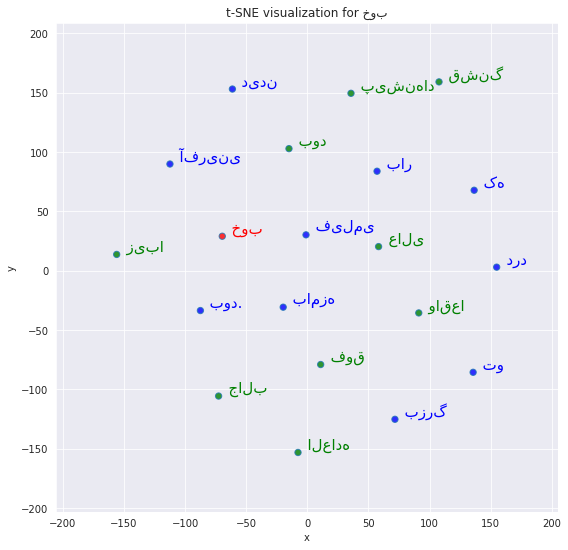

In [36]:
listofword = ['عالی', 'قشنگ', 'پیشنهاد', 'زیبا', 'بود', 'فوق','العاده', 'واقعا', 'جالب']
tsnescatterplot(w2v_model, 'خوب', listofword)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


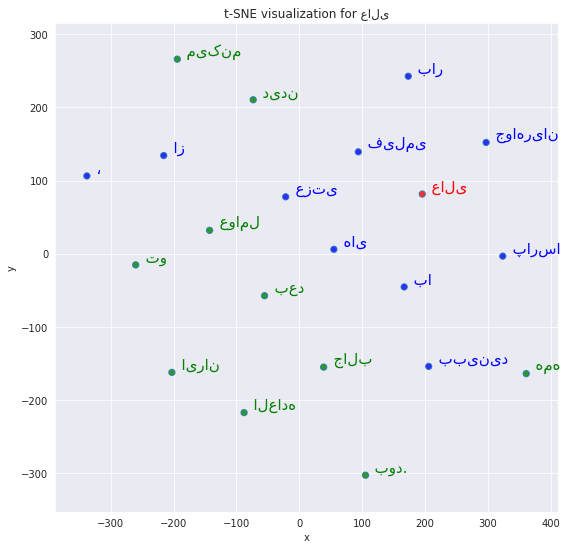

In [37]:
tsnescatterplot(w2v_model, 'عالی', [i[0] for i in w2v_model.wv.most_similar(negative=["عالی"])])

##Getting word similarity for weight words

In [38]:
x = "عالی"
w2v_model.wv.most_similar(positive=[x])

[('فیلمی', 0.25735166668891907),
 ('از', 0.200503408908844),
 ('،', 0.19855839014053345),
 ('های', 0.1807647943496704),
 ('بار', 0.1769590973854065),
 ('پارسا', 0.1753464639186859),
 ('جواهریان', 0.16088369488716125),
 ('عزتی', 0.14725281298160553),
 ('با', 0.1445910930633545),
 ('ببینید', 0.1445724368095398)]

In [39]:
x = "خوب"
w2v_model.wv.most_similar(positive=[x])

[('بود.', 0.23057061433792114),
 ('بزرگ', 0.17563724517822266),
 ('فیلمی', 0.16716060042381287),
 ('دیدن', 0.1634744107723236),
 ('تو', 0.14385637640953064),
 ('آفرینی', 0.14230720698833466),
 ('درد', 0.14091373980045319),
 ('که', 0.1406758427619934),
 ('بار', 0.13018135726451874),
 ('بامزه', 0.1285800337791443)]

In [40]:
x = "قشنگ"
w2v_model.wv.most_similar(positive=[x])

[('فرمان', 0.20163458585739136),
 ('لذت', 0.19065552949905396),
 ('فیلم', 0.1825539469718933),
 ('آفرینی', 0.1747557818889618),
 ('خوبی', 0.17182226479053497),
 ('ای', 0.1606597751379013),
 ('کارگردان', 0.1382228136062622),
 ('کارگردانی', 0.1373421549797058),
 ('یه', 0.13294094800949097),
 ('پیشنهاد', 0.13134098052978516)]

In [41]:
x = "پیشنهاد"
w2v_model.wv.most_similar(positive=[x])

[('عالییییی', 0.20704875886440277),
 ('های', 0.199214905500412),
 ('کارگردانی', 0.193104550242424),
 ('داستان', 0.18775789439678192),
 ('بار', 0.18054604530334473),
 ('بی', 0.17335109412670135),
 ('بود', 0.17311590909957886),
 ('نقش', 0.16022425889968872),
 ('مرسی', 0.15579932928085327),
 ('احسنت', 0.15424613654613495)]

In [42]:
x = "عالی"
y = "پیشنهاد"
z = "قشنگ"
v = "خوب"
word_predict_instance = w2v_model.wv.most_similar(positive=[x, y, z, v])

In [43]:
word_predict_instance

[('فیلمی', 0.27535003423690796),
 ('کارگردانی', 0.21758560836315155),
 ('بار', 0.21535061299800873),
 ('های', 0.21105468273162842),
 ('از', 0.1683465540409088),
 ('جواهریان', 0.16272494196891785),
 ('احسنت', 0.16228868067264557),
 ('که', 0.1590237319469452),
 ('آفرینی', 0.1547035574913025),
 ('پارسا', 0.15276700258255005)]

## sentiment prediction

In [44]:
type(word_predict_instance)

list

In [45]:
nude_word = [x[0] for x in word_predict_instance]

In [46]:
nude_word

['فیلمی',
 'کارگردانی',
 'بار',
 'های',
 'از',
 'جواهریان',
 'احسنت',
 'که',
 'آفرینی',
 'پارسا']

In [47]:
comment_box = []
for comment in data['clean_comment']:
  comment_box.append(comment)

In [48]:
comment_box

['خیلی قشنگه . روزگار الان و خوب به تصویر کشیده',
 'عالی آقای رادان',
 'قشنگ بود',
 'عالییییی',
 'من دیدم خیلی خفنه',
 'باحال بود من خوشم اومد',
 'فیلمی تلخ، ولی واقع گرا',
 'خیلی فیلم خوبی بود. پیشنهاد میشه',
 'خوب بود',
 'دلم برای رها و آرمان سوخت',
 'خیلی عالی بود آخرش بد تموم شد',
 'فیلم خوبی بود',
 'عالییییی',
 'عالی بود ',
 'عالی بود ممنون از سازندش',
 'ترلان پروانه عالی بازی کرد',
 'خیلییییی قشنگ بود پیشنهاد میکنم حتما ببینید',
 'عالی بود',
 'فقط اون فاميلشون و جواب هاى سينا مهراد  عاليه اين فيلم ٤ بار تا حالا ديدم',
 'خیلی عالی بود',
 'عالییییییییییییییههههههههههههههههه',
 'عالییییییییی',
 'خیلی خووووب بود',
 'حتما توصیه میکنم ببینید',
 'بعد از مدتها یه فیلم قشنگ دیدم. همه عالی بودند',
 'واقعا فیلم قشنگی بود فضاش خیلی طبیعی و قابل لمس بود',
 'عالی بود',
 'کمدی خوب',
 'جالب نبود',
 'عالی خیلی خنده داره',
 'عالی',
 'خیلی خوب بود به خصوص قسمتی که میگه هرچی خاک شماست بقای عمرحسن',
 'خوب بود لذت بردم',
 'فیلمی که پارسا پیروزفر و فاطمعه معتمد اریا توش بازی کنند عالیه بی شک .....',
 '

In [49]:
from hazm import word_tokenize


word_token = word_tokenize(str(comment_box))




In [50]:
! pip install datasketch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 6.7 MB/s 


## Jacard similarity for get similarity point of must freq word with comments 

In [51]:
from datasketch import MinHash

data1 = ['بازی', 'عالی','پیشنهاد','خوب', 'بود', 'عالیه','بد', 'نبود', 'فیلم']
data2 = word_token

m1, m2 = MinHash(), MinHash()
for d in data1:
    m1.update(d.encode('utf8'))
for d in data2:
    m2.update(d.encode('utf8'))
print("Estimated Jaccard for data1 and data2 is", m1.jaccard(m2))
s1 = set(data1)
s2 = set(data2)
actual_jaccard = float(len(s1.intersection(s2)))/float(len(s1.union(s2)))
print("Actual Jaccard for data1 and data2 is", actual_jaccard)

Estimated Jaccard for data1 and data2 is 0.0078125
Actual Jaccard for data1 and data2 is 0.02122641509433962


## Cosine Similarity for get similarity point of must freq word with comments

In [52]:
from collections import Counter
from math import sqrt

def word2vec(word):
    # count the characters in word
    cw = Counter(word)
    # precomputes a set of the different characters
    sw = set(cw)
    # precomputes the "length" of the word vector
    lw = sqrt(sum(c*c for c in cw.values()))
    return cw, sw, lw

def cosdis(v1, v2):
    # which characters are common to the two words?
    common = v1[1].intersection(v2[1])
    # by definition of cosine distance we have
    return sum(v1[0][ch]*v2[0][ch] for ch in common)/v1[2]/v2[2]


list_A = ['عالی']
list_B = comment_box

result1 = []

for key in list_A:
    for word in list_B:
      res = cosdis(word2vec(word), word2vec(key))
      result1.append(res)
      print("The cosine similarity between : {} and : {} is: {}".format(word, key, res*100))

The cosine similarity between : خیلی قشنگه . روزگار الان و خوب به تصویر کشیده and : عالی is: 34.412360080584264
The cosine similarity between : عالی آقای رادان and : عالی is: 71.84212081070996
The cosine similarity between : قشنگ بود and : عالی is: 0.0
The cosine similarity between : عالییییی and : عالی is: 75.59289460184544
The cosine similarity between : من دیدم خیلی خفنه and : عالی is: 32.87979746107146
The cosine similarity between : باحال بود من خوشم اومد and : عالی is: 26.72612419124244
The cosine similarity between : فیلمی تلخ، ولی واقع گرا and : عالی is: 63.01260378126044
The cosine similarity between : خیلی فیلم خوبی بود. پیشنهاد میشه and : عالی is: 45.456864504849484
The cosine similarity between : خوب بود and : عالی is: 0.0
The cosine similarity between : دلم برای رها و آرمان سوخت and : عالی is: 32.009219983224
The cosine similarity between : خیلی عالی بود آخرش بد تموم شد and : عالی is: 38.41749099639162
The cosine similarity between : فیلم خوبی بود and : عالی is: 32.7326835

In [ ]:
result1

[0.34412360080584264,
 0.7184212081070996,
 0.0,
 0.7559289460184544,
 0.3287979746107146,
 0.2672612419124244,
 0.6301260378126043,
 0.4545686450484948,
 0.0,
 0.32009219983223997,
 0.3841749099639162,
 0.3273268353539886,
 0.7559289460184544,
 0.6030226891555273,
 0.4008918628686366,
 0.5715005715008572,
 0.4631058249214127,
 0.7071067811865475,
 0.36409999634640144,
 0.7298004491997617,
 0.38477692068070374,
 0.6546536707079772,
 0.228747855498907,
 0.3434014098717226,
 0.39086797998528583,
 0.5218624584427538,
 0.7071067811865475,
 0.17677669529663687,
 0.30151134457776363,
 0.6246950475544243,
 1.0,
 0.3180732125814321,
 0.08838834764831843,
 0.45813068106189153,
 0.4152697672499609,
 0.37647348308289513,
 0.5393598899705937,
 0.36380343755449945,
 0.0,
 0.40147753427348304,
 0.45045960013229974,
 0.4539545862254728,
 0.7071067811865475,
 0.3898846627545847,
 0.5753964555687505,
 0.3136075378219869,
 0.5829988340034981,
 0.5482823149915702,
 0.21320071635561041,
 0.453742606486515

# Now We See Cosine Similarity Have Better Result

## Work Cosine Similarity For other weited words 

In [53]:
d_f = pd.DataFrame()

In [54]:
d_f['perfect_rate'] = result1

In [55]:
def word2vec(word):
    # count the characters in word
    cw = Counter(word)
    # precomputes a set of the different characters
    sw = set(cw)
    # precomputes the "length" of the word vector
    lw = sqrt(sum(c*c for c in cw.values()))
    return cw, sw, lw

def cosdis(v1, v2):
    # which characters are common to the two words?
    common = v1[1].intersection(v2[1])
    # by definition of cosine distance we have
    return sum(v1[0][ch]*v2[0][ch] for ch in common)/v1[2]/v2[2]


list_A = ['خوب']
list_B = comment_box

result2 = []

for key in list_A:
    for word in list_B:
      res = cosdis(word2vec(word), word2vec(key))
      result2.append(res)
      #print("The cosine similarity between : {} and : {} is: {}".format(word, key, res*100))



In [56]:
d_f['good_rate'] = result2

In [57]:
def word2vec(word):
    # count the characters in word
    cw = Counter(word)
    # precomputes a set of the different characters
    sw = set(cw)
    # precomputes the "length" of the word vector
    lw = sqrt(sum(c*c for c in cw.values()))
    return cw, sw, lw

def cosdis(v1, v2):
    # which characters are common to the two words?
    common = v1[1].intersection(v2[1])
    # by definition of cosine distance we have
    return sum(v1[0][ch]*v2[0][ch] for ch in common)/v1[2]/v2[2]


list_A = ['پیشنهاد']
list_B = comment_box

result4 = []

for key in list_A:
    for word in list_B:
      res = cosdis(word2vec(word), word2vec(key))
      result4.append(res)
      #print("The cosine similarity between : {} and : {} is: {}".format(word, key, res*100))



In [58]:
d_f['propose_rate'] = result4

In [59]:
def word2vec(word):
    # count the characters in word
    cw = Counter(word)
    # precomputes a set of the different characters
    sw = set(cw)
    # precomputes the "length" of the word vector
    lw = sqrt(sum(c*c for c in cw.values()))
    return cw, sw, lw

def cosdis(v1, v2):
    # which characters are common to the two words?
    common = v1[1].intersection(v2[1])
    # by definition of cosine distance we have
    return sum(v1[0][ch]*v2[0][ch] for ch in common)/v1[2]/v2[2]


list_A = ['بد']
list_B = comment_box

result3 = []

for key in list_A:
    for word in list_B:
      res = cosdis(word2vec(word), word2vec(key))
      result3.append(res)
      #print("The cosine similarity between : {} and : {} is: {}".format(word, key, res*100))



In [68]:
d_f['bad_rate'] = result3

In [60]:
def word2vec(word):
    # count the characters in word
    cw = Counter(word)
    # precomputes a set of the different characters
    sw = set(cw)
    # precomputes the "length" of the word vector
    lw = sqrt(sum(c*c for c in cw.values()))
    return cw, sw, lw

def cosdis(v1, v2):
    # which characters are common to the two words?
    common = v1[1].intersection(v2[1])
    # by definition of cosine distance we have
    return sum(v1[0][ch]*v2[0][ch] for ch in common)/v1[2]/v2[2]


list_A = ['نبود']
list_B = comment_box

result5 = []

for key in list_A:
    for word in list_B:
      res = cosdis(word2vec(word), word2vec(key))
      result5.append(res)
      #print("The cosine similarity between : {} and : {} is: {}".format(word, key, res*100))



In [61]:
d_f['not_rate'] = result5

In [64]:
def word2vec(word):
    # count the characters in word
    cw = Counter(word)
    # precomputes a set of the different characters
    sw = set(cw)
    # precomputes the "length" of the word vector
    lw = sqrt(sum(c*c for c in cw.values()))
    return cw, sw, lw

def cosdis(v1, v2):
    # which characters are common to the two words?
    common = v1[1].intersection(v2[1])
    # by definition of cosine distance we have
    return sum(v1[0][ch]*v2[0][ch] for ch in common)/v1[2]/v2[2]


list_A = ['فیلم']
list_B = comment_box

result6 = []

for key in list_A:
    for word in list_B:
      res = cosdis(word2vec(word), word2vec(key))
      result6.append(res)
     # print("The cosine similarity between : {} and : {} is: {}".format(word, key, res*100))



In [65]:
d_f['film_rate'] = result6

In [66]:
def word2vec(word):
    # count the characters in word
    cw = Counter(word)
    # precomputes a set of the different characters
    sw = set(cw)
    # precomputes the "length" of the word vector
    lw = sqrt(sum(c*c for c in cw.values()))
    return cw, sw, lw

def cosdis(v1, v2):
    # which characters are common to the two words?
    common = v1[1].intersection(v2[1])
    # by definition of cosine distance we have
    return sum(v1[0][ch]*v2[0][ch] for ch in common)/v1[2]/v2[2]


list_A = ['بازی']
list_B = comment_box

result7 = []

for key in list_A:
    for word in list_B:
      res = cosdis(word2vec(word), word2vec(key))
      result7.append(res)
      #print("The cosine similarity between : {} and : {} is: {}".format(word, key, res*100))

d_f['roleplay_rate'] = result7

### I Get point of similarity for weited words and build dataframe with that

In [70]:
d_f

,perfect_rate,good_rate,propose_rate,not_rate,film_rate,roleplay_rate,bad_rate
0,0.344124,0.353209,0.433555,0.344124,0.229416,0.382360,0.162221
1,0.718421,0.000000,0.543075,0.179605,0.269408,0.538816,0.127000
2,0.000000,0.408248,0.400892,0.707107,0.000000,0.176777,0.500000
3,0.755929,0.000000,0.428571,0.000000,0.566947,0.566947,0.000000
4,0.328798,0.189832,0.497096,0.328798,0.575396,0.246598,0.232495
...,...,...,...,...,...,...,...
123,0.182574,0.527046,0.207020,0.456435,0.091287,0.365148,0.387298
124,0.447214,0.129099,0.507093,0.335410,0.447214,0.223607,0.158114
125,0.316228,0.547723,0.239046,0.632456,0.158114,0.474342,0.670820
126,0.508913,0.195881,0.544995,0.424094,0.424094,0.466504,0.359856


In [71]:
d_f['film_name'] = data['film_name']

In [72]:
d_f

,perfect_rate,good_rate,propose_rate,not_rate,film_rate,roleplay_rate,bad_rate,film_name
0,0.344124,0.353209,0.433555,0.344124,0.229416,0.382360,0.162221,BlackCat
1,0.718421,0.000000,0.543075,0.179605,0.269408,0.538816,0.127000,BlackCat
2,0.000000,0.408248,0.400892,0.707107,0.000000,0.176777,0.500000,BlackCat
3,0.755929,0.000000,0.428571,0.000000,0.566947,0.566947,0.000000,BlackCat
4,0.328798,0.189832,0.497096,0.328798,0.575396,0.246598,0.232495,BlackCat
...,...,...,...,...,...,...,...,...
123,0.182574,0.527046,0.207020,0.456435,0.091287,0.365148,0.387298,Death_of_Salesman
124,0.447214,0.129099,0.507093,0.335410,0.447214,0.223607,0.158114,Death_of_Salesman
125,0.316228,0.547723,0.239046,0.632456,0.158114,0.474342,0.670820,Death_of_Salesman
126,0.508913,0.195881,0.544995,0.424094,0.424094,0.466504,0.359856,Death_of_Salesman


In [73]:
d_f['comment'] = data['clean_comment']

In [74]:
df = d_f

In [75]:
df.head()

,perfect_rate,good_rate,propose_rate,not_rate,film_rate,roleplay_rate,bad_rate,film_name,comment
0,0.344124,0.353209,0.433555,0.344124,0.229416,0.382360,0.162221,BlackCat,خیلی قشنگه . روزگار الان و خوب به تصویر کشیده
1,0.718421,0.000000,0.543075,0.179605,0.269408,0.538816,0.127000,BlackCat,عالی آقای رادان
2,0.000000,0.408248,0.400892,0.707107,0.000000,0.176777,0.500000,BlackCat,قشنگ بود
3,0.755929,0.000000,0.428571,0.000000,0.566947,0.566947,0.000000,BlackCat,عالییییی
4,0.328798,0.189832,0.497096,0.328798,0.575396,0.246598,0.232495,BlackCat,من دیدم خیلی خفنه


In [76]:
df = df[['comment', 'film_name', 'roleplay_rate', 'film_rate', 'not_rate', 'bad_rate', 'propose_rate', 'good_rate', 'perfect_rate']]

### Now We have New DataFrame with comments, film_name label and points of similariy must weighted words for each comments

In [78]:
df.head(10)

,comment,film_name,roleplay_rate,film_rate,not_rate,bad_rate,propose_rate,good_rate,perfect_rate
0,خیلی قشنگه . روزگار الان و خوب به تصویر کشیده,BlackCat,0.382360,0.229416,0.344124,0.162221,0.433555,0.353209,0.344124
1,عالی آقای رادان,BlackCat,0.538816,0.269408,0.179605,0.127000,0.543075,0.000000,0.718421
2,قشنگ بود,BlackCat,0.176777,0.000000,0.707107,0.500000,0.400892,0.408248,0.000000
3,عالییییی,BlackCat,0.566947,0.566947,0.000000,0.000000,0.428571,0.000000,0.755929
4,من دیدم خیلی خفنه,BlackCat,0.246598,0.575396,0.328798,0.232495,0.497096,0.189832,0.328798
5,باحال بود من خوشم اومد,BlackCat,0.334077,0.267261,0.534522,0.377964,0.353553,0.462910,0.267261
6,فیلمی تلخ، ولی واقع گرا,BlackCat,0.350070,0.560112,0.140028,0.000000,0.264628,0.242536,0.630126
7,خیلی فیلم خوبی بود. پیشنهاد میشه,BlackCat,0.454569,0.555584,0.353553,0.285714,0.572703,0.349927,0.454569
8,خوب بود,BlackCat,0.301511,0.000000,0.753778,0.639602,0.113961,0.870388,0.000000
9,دلم برای رها و آرمان سوخت,BlackCat,0.320092,0.256074,0.320092,0.181071,0.338754,0.295689,0.320092


## adding new columns Nmae that sentiment for set sentiment for each coment

In [79]:
df['sentiment'] = 1.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
df.head()

,comment,film_name,roleplay_rate,film_rate,not_rate,bad_rate,propose_rate,good_rate,perfect_rate,sentiment
0,خیلی قشنگه . روزگار الان و خوب به تصویر کشیده,BlackCat,0.382360,0.229416,0.344124,0.162221,0.433555,0.353209,0.344124,1.0
1,عالی آقای رادان,BlackCat,0.538816,0.269408,0.179605,0.127000,0.543075,0.000000,0.718421,1.0
2,قشنگ بود,BlackCat,0.176777,0.000000,0.707107,0.500000,0.400892,0.408248,0.000000,1.0
3,عالییییی,BlackCat,0.566947,0.566947,0.000000,0.000000,0.428571,0.000000,0.755929,1.0
4,من دیدم خیلی خفنه,BlackCat,0.246598,0.575396,0.328798,0.232495,0.497096,0.189832,0.328798,1.0


## Now for Set Sentiment labels Calcuting Mean Of rate point 

In [82]:
def rate_mean():
  x = (df['roleplay_rate'] + df['film_rate'] + df['not_rate'] + 
       df['bad_rate'] + df['propose_rate'] + df['good_rate'] +
       df['perfect_rate'] )
  rs = x / 7
  return rs

In [83]:
df['rate_mean'] = rate_mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [84]:
df.head()

,comment,film_name,roleplay_rate,film_rate,not_rate,bad_rate,propose_rate,good_rate,perfect_rate,sentiment,rate_mean
0,خیلی قشنگه . روزگار الان و خوب به تصویر کشیده,BlackCat,0.382360,0.229416,0.344124,0.162221,0.433555,0.353209,0.344124,1.0,0.321287
1,عالی آقای رادان,BlackCat,0.538816,0.269408,0.179605,0.127000,0.543075,0.000000,0.718421,1.0,0.339475
2,قشنگ بود,BlackCat,0.176777,0.000000,0.707107,0.500000,0.400892,0.408248,0.000000,1.0,0.313289
3,عالییییی,BlackCat,0.566947,0.566947,0.000000,0.000000,0.428571,0.000000,0.755929,1.0,0.331199
4,من دیدم خیلی خفنه,BlackCat,0.246598,0.575396,0.328798,0.232495,0.497096,0.189832,0.328798,1.0,0.342716


## Set Label

In [85]:
A = []
for i in df['rate_mean']:
  if i > 0.30:
    A.append('positive')
  else:
    A.append("negative")  
  
df['sentiment'] = A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [86]:
df

,comment,film_name,roleplay_rate,film_rate,not_rate,bad_rate,propose_rate,good_rate,perfect_rate,sentiment,rate_mean
0,خیلی قشنگه . روزگار الان و خوب به تصویر کشیده,BlackCat,0.382360,0.229416,0.344124,0.162221,0.433555,0.353209,0.344124,positive,0.321287
1,عالی آقای رادان,BlackCat,0.538816,0.269408,0.179605,0.127000,0.543075,0.000000,0.718421,positive,0.339475
2,قشنگ بود,BlackCat,0.176777,0.000000,0.707107,0.500000,0.400892,0.408248,0.000000,positive,0.313289
3,عالییییی,BlackCat,0.566947,0.566947,0.000000,0.000000,0.428571,0.000000,0.755929,positive,0.331199
4,من دیدم خیلی خفنه,BlackCat,0.246598,0.575396,0.328798,0.232495,0.497096,0.189832,0.328798,positive,0.342716
...,...,...,...,...,...,...,...,...,...,...,...
123,بسیار خوب و درست,Death_of_Salesman,0.365148,0.091287,0.456435,0.387298,0.207020,0.527046,0.182574,positive,0.316687
124,مرگ فروشنده عالی,Death_of_Salesman,0.223607,0.447214,0.335410,0.158114,0.507093,0.129099,0.447214,positive,0.321107
125,جالب بود,Death_of_Salesman,0.474342,0.158114,0.632456,0.670820,0.239046,0.547723,0.316228,positive,0.434104
126,عالی بود احسنت به امید فیلم های جدیدتون,Death_of_Salesman,0.466504,0.424094,0.424094,0.359856,0.544995,0.195881,0.508913,positive,0.417763


In [87]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

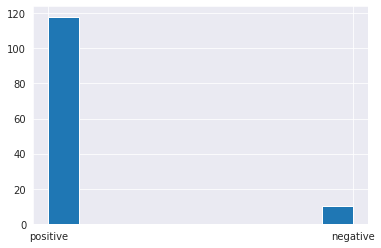

In [88]:
import matplotlib.pyplot as plt

plt.hist(df['sentiment'])
plt.show()

#Conclusion

In [96]:
df.drop(columns=['roleplay_rate','comment','perfect_rate', 'good_rate', 'film_rate', 'not_rate', 'bad_rate', 'propose_rate', 'rate_mean'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [97]:
df.head(10)

,film_name,sentiment
0,BlackCat,positive
1,BlackCat,positive
2,BlackCat,positive
3,BlackCat,positive
4,BlackCat,positive
5,BlackCat,positive
6,BlackCat,positive
7,BlackCat,positive
8,BlackCat,positive
9,BlackCat,negative


In [168]:
df.groupby(by=["sentiment"]).count()

,film_name
sentiment,
negative,10
positive,118


In [167]:

df.groupby(by=["film_name"]).count()


,sentiment
film_name,
BlackCat,18
Death_of_Salesman,10
Departed,15
Facing_Mirrors,23
LoserMan,22
NoChoice,20
The_Late_Father,20


In [169]:
print(df.groupby(by=["sentiment"]).count())
print(f'percent of data label for each film: {10 / 128 *100}')

           film_name
sentiment           
negative          10
positive         118
percent of data label for each film: 7.8125


In [172]:
def percent_of_negative_lebel_for_each_film(x):
  perc = 10 /128 
  neg_perc = perc * x
  return neg_perc

In [179]:
print(f' Score of Ngative Sentiment for "BalckCats" film: {format(percent_of_negative_lebel_for_each_film(18), ".2f")}')
print(f' Score of Ngative Sentiment for "Death_of_Salesman" film: {format(percent_of_negative_lebel_for_each_film(10), ".2f")}')
print(f' Score of Ngative Sentiment for "Departed" film: {format(percent_of_negative_lebel_for_each_film(15), ".2f")}')
print(f' Score of Ngative Sentiment for "Facing_Mirrors" film: {format(percent_of_negative_lebel_for_each_film(23), ".2f")}')
print(f' Score of Ngative Sentiment for "LoserMan" film: {format(percent_of_negative_lebel_for_each_film(22), ".2f")}')
print(f' Score of Ngative Sentiment for "NoChoice" film: {format(percent_of_negative_lebel_for_each_film(20), ".2f")}')
print(f' Score of Ngative Sentiment for "The_Late_Father" film: {format(percent_of_negative_lebel_for_each_film(20), ".2f")}')


 Score of Ngative Sentiment for "BalckCats" film: 1.41
 Score of Ngative Sentiment for "Death_of_Salesman" film: 0.78
 Score of Ngative Sentiment for "Departed" film: 1.17
 Score of Ngative Sentiment for "Facing_Mirrors" film: 1.80
 Score of Ngative Sentiment for "LoserMan" film: 1.72
 Score of Ngative Sentiment for "NoChoice" film: 1.56
 Score of Ngative Sentiment for "The_Late_Father" film: 1.56


In [176]:
def percent_of_psitive_lebel_for_each_film(x):
  perc = 118 /128 
  pos_perc = perc * x
  return pos_perc

In [180]:
print(f' Score of Positive Sentiment for "BalckCats" film: {format(percent_of_psitive_lebel_for_each_film(18), ".2f")}')
print(f' Score of Positive Sentiment for "Death_of_Salesman	" film: {format(percent_of_psitive_lebel_for_each_film(10), ".2f")}')
print(f' Score of Positive Sentiment for "Departed" film: {format(percent_of_psitive_lebel_for_each_film(15), ".2f")}')
print(f' Score of Positive Sentiment for "Facing_Mirrors" film: {format(percent_of_psitive_lebel_for_each_film(23), ".2f")}')
print(f' Score of Positive Sentiment for "LoserMan" film: {format(percent_of_psitive_lebel_for_each_film(22), ".2f")}')
print(f' Score of Positive Sentiment for "NoChoice" film: {format(percent_of_psitive_lebel_for_each_film(20), ".2f")}')
print(f' Score of Positive Sentiment for "The_Late_Father" film: {format(percent_of_psitive_lebel_for_each_film(20), ".2f")}')

 Score of Positive Sentiment for "BalckCats" film: 16.59
 Score of Positive Sentiment for "Death_of_Salesman	" film: 9.22
 Score of Positive Sentiment for "Departed" film: 13.83
 Score of Positive Sentiment for "Facing_Mirrors" film: 21.20
 Score of Positive Sentiment for "LoserMan" film: 20.28
 Score of Positive Sentiment for "NoChoice" film: 18.44
 Score of Positive Sentiment for "The_Late_Father" film: 18.44
